Reactive Autoscaling
  Total cost: 402.50
  Compute cost: 271.50
  SLA penalty: 131.00
  Overload events: 262
  Avg instances: 1.05
  Scale up: 185
  Scale down: 185

Predictive Autoscaling (XGBoost)
  Total cost: 321.52
  Compute cost: 261.52
  SLA penalty: 60.00
  Overload events: 120
  Avg instances: 1.01
  Scale up: 79
  Scale down: 79


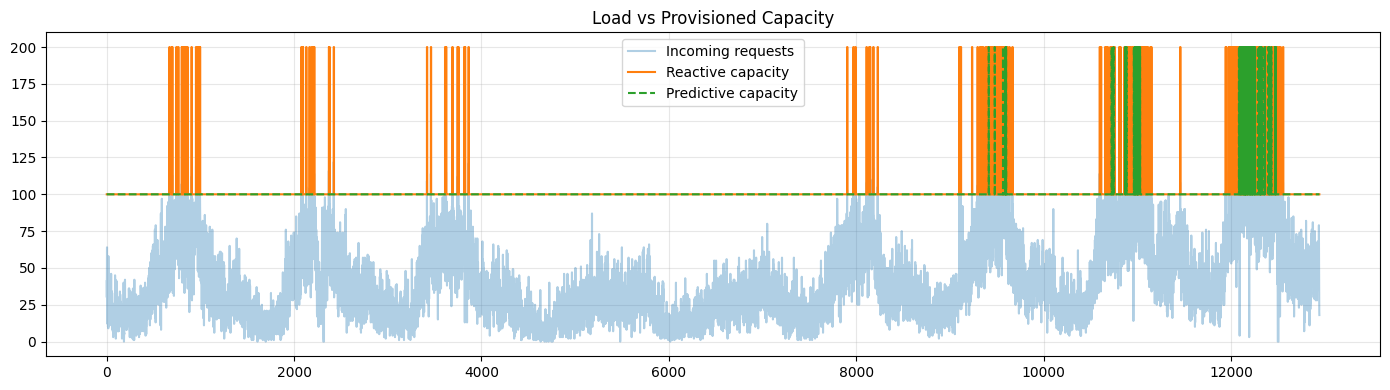

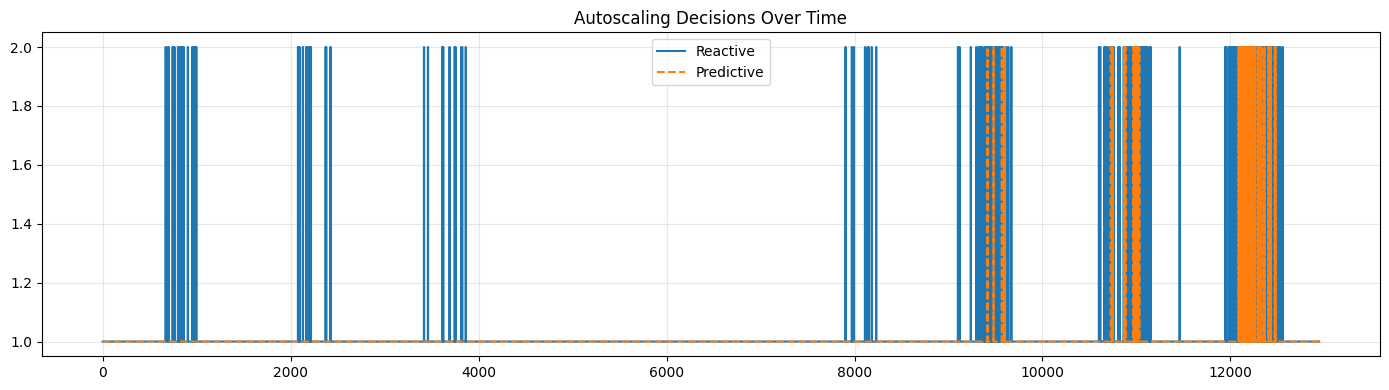

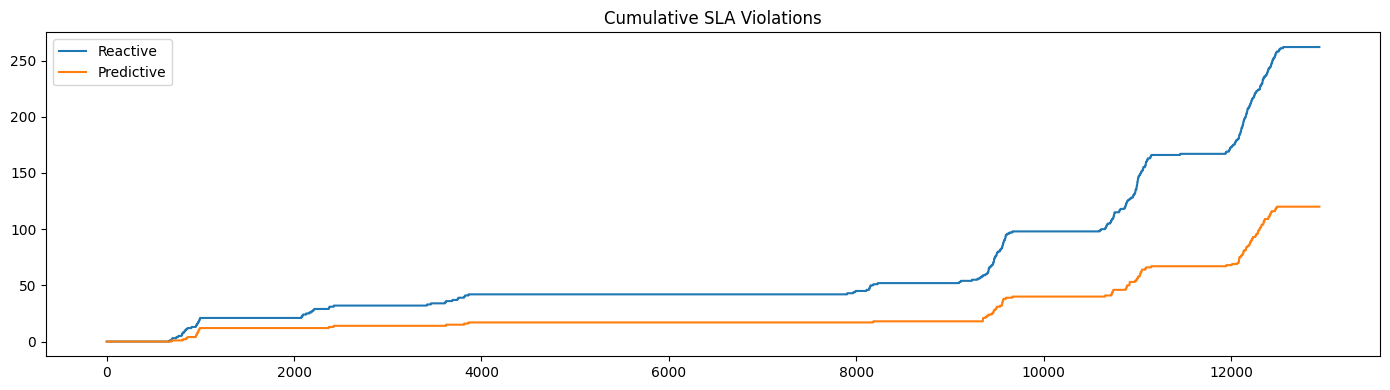

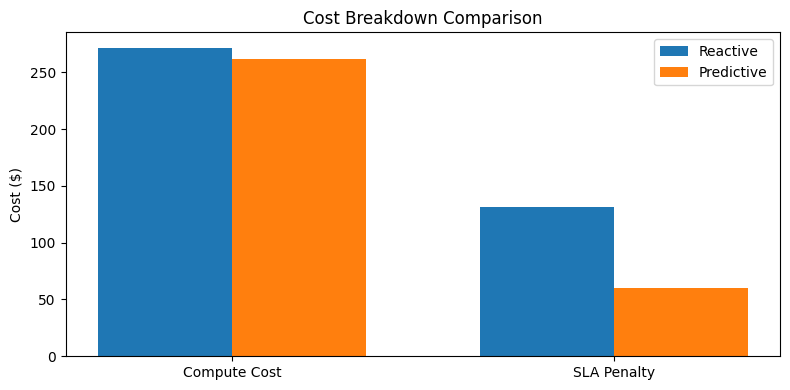

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==============================
# LOAD ACTUAL METRICS
# ==============================
metrics = pd.read_csv("../data/processed/metrics_full.csv")
metrics["timestamp"] = pd.to_datetime(metrics["timestamp"])
metrics = metrics.set_index("timestamp")

# ==============================
# LOAD XGBOOST FORECAST (5 MIN)
# ==============================
forecast = pd.read_csv("../data/processed/xgb_forecast_5m.csv")
forecast["timestamp"] = pd.to_datetime(forecast["timestamp"])
forecast = forecast.set_index("timestamp")

# ==============================
# TRAIN / TEST SPLIT
# ==============================
SPLIT_DATE = "1995-08-23"

metrics_test = metrics.loc[metrics.index >= SPLIT_DATE]
forecast_test = forecast.loc[forecast.index >= SPLIT_DATE]

# ==============================
# EXTRACT WORKLOAD
# ==============================
requests = metrics_test["requests"].values
bytes_ = metrics_test["bytes"].values

forecast_req = forecast_test["requests_pred_5m"].values
forecast_bytes = forecast_test["bytes_pred_5m"].values

# Align length (IMPORTANT)
min_len = min(
    len(requests),
    len(forecast_req)
)

requests = requests[:min_len]
bytes_ = bytes_[:min_len]
forecast_req = forecast_req[:min_len]
forecast_bytes = forecast_bytes[:min_len]

# ==============================
# SYSTEM CAPACITY
# ==============================
CAPACITY_REQ = 100        # requests / min / instance
CAPACITY_BYTES = 5e6     # bytes / min / instance (~5MB)

# ==============================
# COST MODEL
# ==============================
COST_PER_INSTANCE_MIN = 0.02
SLA_PENALTY_PER_MIN = 0.5

# ==============================
# AUTOSCALING CONFIG
# ==============================
MIN_INSTANCES = 1
MAX_INSTANCES = 10
COOLDOWN = 3              # minutes (scale down only)
SAFETY_MARGIN = 1.15      # predictive buffer

# ==============================
# REACTIVE AUTOSCALING                                                                                              
# ==============================
def reactive_autoscaling(req_actual, bytes_actual):
    instances = MIN_INSTANCES
    cooldown = 0

    inst_hist = []
    overload_hist = []
    scale_up = scale_down = 0

    for r, b in zip(req_actual, bytes_actual):
        capacity_req = instances * CAPACITY_REQ
        capacity_bytes = instances * CAPACITY_BYTES

        overload = (r > capacity_req) or (b > capacity_bytes)
        overload_hist.append(overload)

        if cooldown == 0:
            if overload and instances < MAX_INSTANCES:
                instances += 1
                scale_up += 1
                cooldown = COOLDOWN

            elif (
                r < 0.5 * capacity_req
                and b < 0.5 * capacity_bytes
                and instances > MIN_INSTANCES
            ):
                instances -= 1
                scale_down += 1
                cooldown = COOLDOWN

        cooldown = max(0, cooldown - 1)
        inst_hist.append(instances)

    return (
        np.array(inst_hist),
        np.array(overload_hist),
        scale_up,
        scale_down,
    )

# ==============================
# PREDICTIVE AUTOSCALING (XGB)
# ==============================
def predictive_autoscaling(
    req_forecast,
    bytes_forecast,
    req_actual,
    bytes_actual,
):
    instances = MIN_INSTANCES
    cooldown = 0

    inst_hist = []
    overload_hist = []
    scale_up = scale_down = 0

    for r_f, b_f, r, b in zip(
        req_forecast,
        bytes_forecast,
        req_actual,
        bytes_actual,
    ):
        required_instances = max(
            int(np.ceil(r_f / CAPACITY_REQ)),
            int(np.ceil(b_f / CAPACITY_BYTES)),
            MIN_INSTANCES,
        )
        required_instances = min(required_instances, MAX_INSTANCES)

        # Scale UP immediately
        if required_instances > instances:
            scale_up += (required_instances - instances)
            instances = required_instances
            cooldown = 0

        # Scale DOWN conservatively
        elif required_instances < instances and cooldown == 0:
            instances -= 1
            scale_down += 1
            cooldown = COOLDOWN

        # SLA check on ACTUAL load
        capacity_req = instances * CAPACITY_REQ * SAFETY_MARGIN
        capacity_bytes = instances * CAPACITY_BYTES * SAFETY_MARGIN

        overload = (r > capacity_req) or (b > capacity_bytes)
        overload_hist.append(overload)

        inst_hist.append(instances)
        cooldown = max(0, cooldown - 1)

    return (
        np.array(inst_hist),
        np.array(overload_hist),
        scale_up,
        scale_down,
    )

# ==============================
# COST FUNCTION
# ==============================
def compute_cost(instances, overload):
    compute_cost = np.sum(instances * COST_PER_INSTANCE_MIN)
    sla_penalty = np.sum(overload) * SLA_PENALTY_PER_MIN
    return compute_cost, sla_penalty, compute_cost + sla_penalty

# ==============================
# RUN SIMULATION
# ==============================
reactive_instances, reactive_overload, r_up, r_down = reactive_autoscaling(
    requests, bytes_
)

predictive_instances, predictive_overload, p_up, p_down = predictive_autoscaling(
    forecast_req,
    forecast_bytes,
    requests,
    bytes_,
)

r_compute, r_sla, r_total = compute_cost(
    reactive_instances, reactive_overload
)

p_compute, p_sla, p_total = compute_cost(
    predictive_instances, predictive_overload
)

# ==============================
# PRINT RESULTS
# ==============================
print("Reactive Autoscaling")
print(f"  Total cost: {r_total:.2f}")
print(f"  Compute cost: {r_compute:.2f}")
print(f"  SLA penalty: {r_sla:.2f}")
print(f"  Overload events: {reactive_overload.sum()}")
print(f"  Avg instances: {reactive_instances.mean():.2f}")
print(f"  Scale up: {r_up}")
print(f"  Scale down: {r_down}")

print("\nPredictive Autoscaling (XGBoost)")
print(f"  Total cost: {p_total:.2f}")
print(f"  Compute cost: {p_compute:.2f}")
print(f"  SLA penalty: {p_sla:.2f}")
print(f"  Overload events: {predictive_overload.sum()}")
print(f"  Avg instances: {predictive_instances.mean():.2f}")
print(f"  Scale up: {p_up}")
print(f"  Scale down: {p_down}")

# ==============================
# VISUALIZATION
# ==============================
T = np.arange(len(requests))

plt.figure(figsize=(14, 4))
plt.plot(T, requests, label="Incoming requests", alpha=0.35)
plt.step(T, reactive_instances * CAPACITY_REQ, where="post", label="Reactive capacity")
plt.step(
    T,
    predictive_instances * CAPACITY_REQ,
    where="post",
    linestyle="--",
    label="Predictive capacity",
)
plt.legend()
plt.title("Load vs Provisioned Capacity")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.step(T, reactive_instances, where="post", label="Reactive")
plt.step(T, predictive_instances, where="post", linestyle="--", label="Predictive")
plt.legend()
plt.title("Autoscaling Decisions Over Time")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
plt.plot(np.cumsum(reactive_overload), label="Reactive")
plt.plot(np.cumsum(predictive_overload), label="Predictive")
plt.legend()
plt.title("Cumulative SLA Violations")
plt.tight_layout()
plt.show()

labels = ["Compute Cost", "SLA Penalty"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width / 2, [r_compute, r_sla], width, label="Reactive")
plt.bar(x + width / 2, [p_compute, p_sla], width, label="Predictive")
plt.xticks(x, labels)
plt.ylabel("Cost ($)")
plt.legend()
plt.title("Cost Breakdown Comparison")
plt.tight_layout()
plt.show()
